In [1]:
%pip install lightning umap-learn datasets

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [24]:
import os
from torch import optim, nn, utils, Tensor
from torchvision.datasets import MNIST,CIFAR100,EuroSAT
from torchvision.transforms import ToTensor
import lightning as L
from torchvision.models import resnet18, ResNet18_Weights,vgg19,VGG19_Weights
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from scipy.stats import beta,entropy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
!git clone https://github.com/GabrielVogel/Anomaly-Detection---INF01050.git

Cloning into 'Anomaly-Detection---INF01050'...
remote: Enumerating objects: 24338, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 24338 (delta 0), reused 0 (delta 0), pack-reused 24335
Receiving objects: 100% (24338/24338), 150.92 MiB | 50.17 MiB/s, done.
Updating files: 100% (24301/24301), done.


In [4]:
def remove_last_layer(model):
    children = list(model.children())[:-1]
    model_ = nn.Sequential(*children)
    return model_

In [6]:
%cd Anomaly-Detection---INF01050
from models import ModelWithDropout

/content/Anomaly-Detection---INF01050


In [7]:
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
preprocess = weights.transforms()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]


In [8]:
m = remove_last_layer(model)
model_with_dropout = ModelWithDropout(10.,m,10)

In [9]:
from torchvision.datasets import ImageFolder

## Training

In [10]:
train = ImageFolder("/content/Anomaly-Detection---INF01050/train",transform=preprocess)
val = ImageFolder("/content/Anomaly-Detection---INF01050/val",transform=preprocess)
test = ImageFolder("/content/Anomaly-Detection---INF01050/test",transform=preprocess)


In [11]:
batch_size = 32
trainloader = DataLoader(train, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = DataLoader(val, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
testloader = DataLoader(test, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [12]:
trainer = L.Trainer(max_epochs=8)
trainer.fit(model_with_dropout,trainloader,valloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type       | Params | Mode 
------------------------------------------------
0 | backbone | Sequential | 11.2 M | train
1 | l1       | Linear     | 131 K  | train
2 | drop     | Dropout    | 0      | train
3 | l2       | Linear     | 2.6 K  | train
------------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.242    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_s

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=8` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=8` reached.


In [14]:
predictions = trainer.predict(model_with_dropout, testloader)
preds_ = torch.concatenate(predictions)
preds = preds_.argmax(axis=1).numpy()
y_true = np.array(testloader.dataset.targets)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Predicting: |          | 0/? [00:00<?, ?it/s]

In [16]:
(preds == y_true).mean()

0.9729629629629629

# Validation stats

In [17]:
val_predictions = torch.concatenate(trainer.predict(model_with_dropout, valloader))

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

torch.return_types.max(
values=tensor([0.8205, 0.9701, 0.9939,  ..., 0.9710, 0.9935, 0.9934]),
indices=tensor([0, 0, 0,  ..., 9, 9, 9]))

In [51]:
conf, label = val_predictions.max(dim=1)
entropy_val = torch.tensor(entropy(val_predictions,axis=1))

In [52]:
q = torch.quantile(conf,0.05)
q_entropy = torch.quantile(entropy_val,0.95)

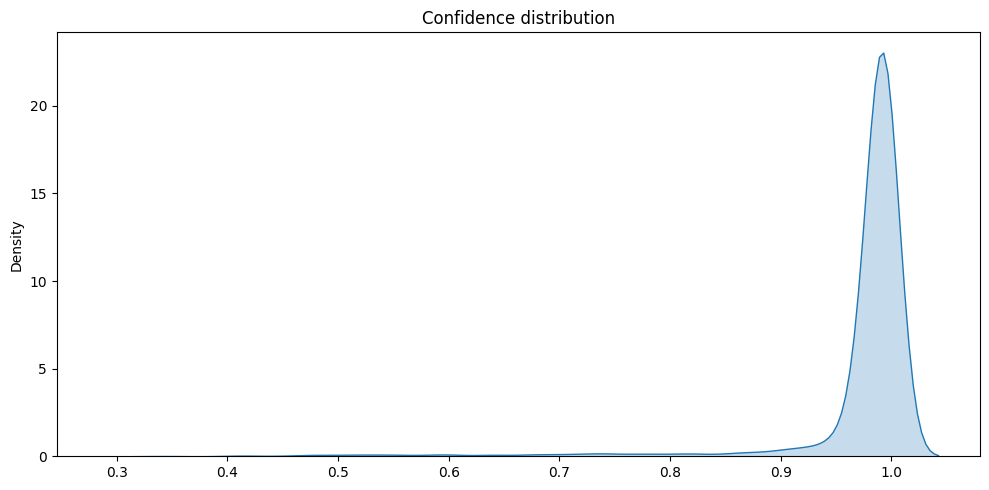

In [55]:
fig,ax = plt.subplots(figsize=(10,5))
_ = sns.kdeplot(conf,ax=ax,fill=True)
ax.set_title("Confidence distribution")
plt.tight_layout()

## OOD

In [31]:
import torchvision
oodloader = torchvision.datasets.CIFAR10(root='./data',train=False,
                                       download=True, transform=preprocess)
ood_loader = torch.utils.data.DataLoader(oodloader, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 79294258.46it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [33]:
ood_preds = torch.concatenate(trainer.predict(model_with_dropout, ood_loader))

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Predicting: |          | 0/? [00:00<?, ?it/s]

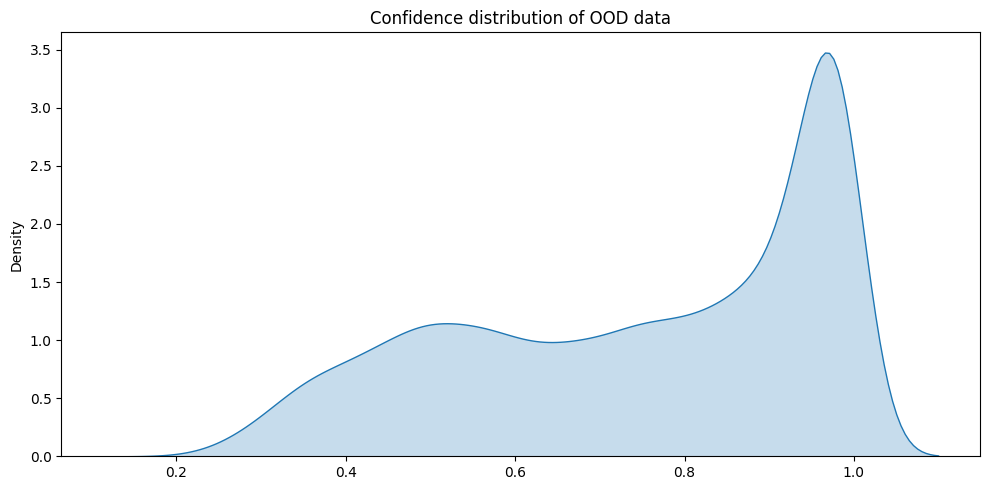

In [59]:
conf_ood, label = ood_preds.max(dim=1)
entropy_ood = torch.tensor(entropy(ood_preds,axis=1))
fig,ax = plt.subplots(figsize=(10,5))
_ = sns.kdeplot(conf_ood,ax=ax,fill=True)
ax.set_title("Confidence distribution of OOD data")
plt.tight_layout()

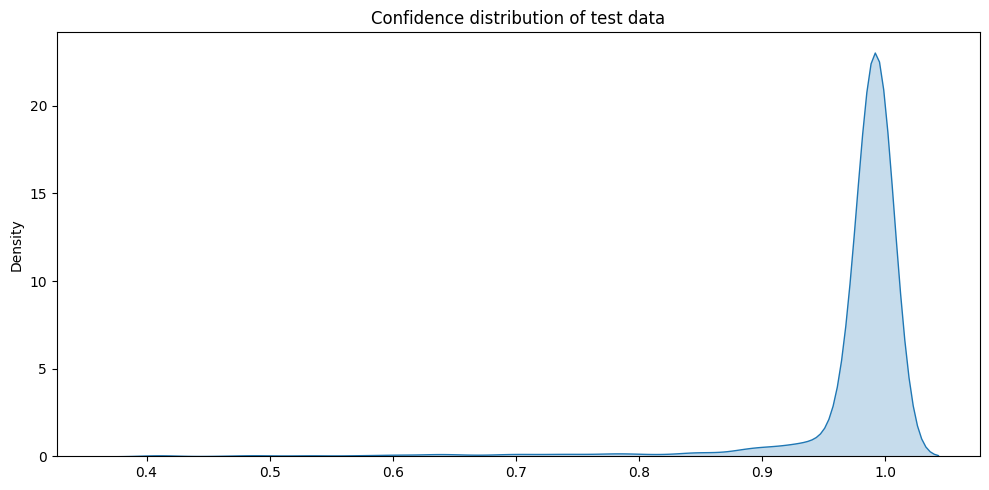

In [60]:
conf_testdata, label = preds_.max(dim=1)
entropy_test = torch.tensor(entropy(preds_,axis=1))
fig,ax = plt.subplots(figsize=(10,5))
_ = sns.kdeplot(conf_testdata,ax=ax,fill=True)
ax.set_title("Confidence distribution of test data")
plt.tight_layout()

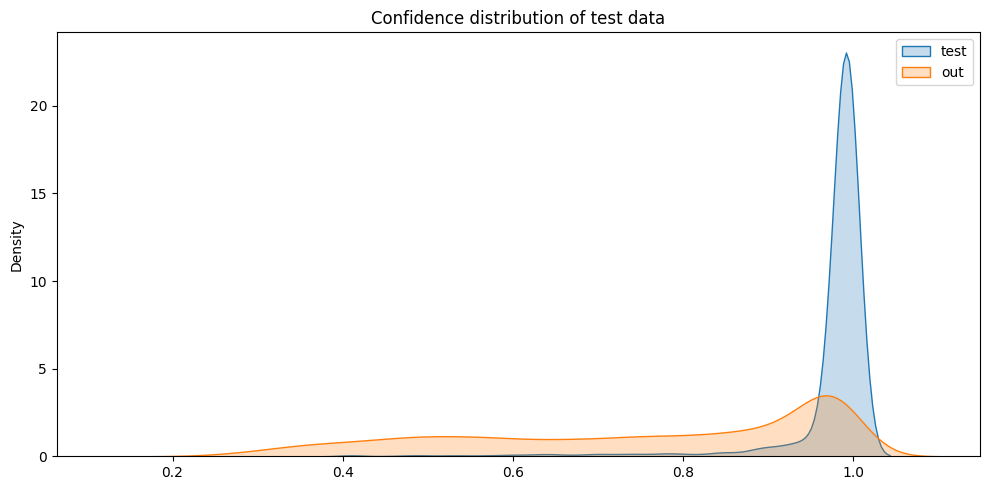

In [61]:
fig,ax = plt.subplots(figsize=(10,5))
_ = sns.kdeplot(conf_testdata,ax=ax,fill=True,label="test")
_ = sns.kdeplot(conf_ood,ax=ax,fill=True,label="out")
ax.set_title("Confidence distribution of test data")
ax.legend()
plt.tight_layout()

In [64]:
(conf_ood <= q).float().mean()

tensor(0.5817)

In [65]:
(entropy_ood >= q_entropy).float().mean()

tensor(0.6070)

In [71]:
from sklearn.metrics import roc_auc_score
labels = [1]*len(entropy_ood) + [0]*len(entropy_test)
scores = list(entropy_ood.numpy()) + list(entropy_test.numpy())
roc_auc_score(labels,scores)

0.9276917407407407